In [1]:

import warnings
warnings.filterwarnings('ignore')

In [2]:

from time import time
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
from numpy.linalg import LinAlgError

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
Path( 'data')

WindowsPath('data')

In [5]:
DATA_PATH = Path( 'data')
STORE = DATA_PATH / 'assets.h5'

In [6]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [7]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

In [8]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

In [9]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [10]:

def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

In [11]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([
            store[f'stooq/us/nasdaq/{asset_class}/prices'],
            store[f'stooq/us/nyse/{asset_class}/prices']
        ]).sort_index().loc[idx[:, str(start):str(end)], :])
        df = df.reset_index().drop_duplicates().set_index(['ticker', 'date'])
        df['dv'] = df.close.mul(df.volume)
        dv = df.groupby(level='ticker').dv.mean().nlargest(n=n).index
        df = (df.loc[idx[dv, :],
                     'close'].unstack('ticker').ffill(limit=5).dropna(axis=1))

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [21]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
#     df.to_hdf('data.h5', f'{asset_class}/close')

In [13]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [14]:
names = get_ticker_dict()

In [15]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 171 entries, AAPL.US to BDX.US
dtypes: float64(171)
memory usage: 3.3 MB


In [16]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 137 entries, SPY.US to DBB.US
dtypes: float64(137)
memory usage: 2.6 MB


In [17]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
# pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [18]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [19]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, AAPL.US to BDX.US
Columns: 137 entries, SPY.US to DBB.US
dtypes: float64(137)
memory usage: 188.4+ KB


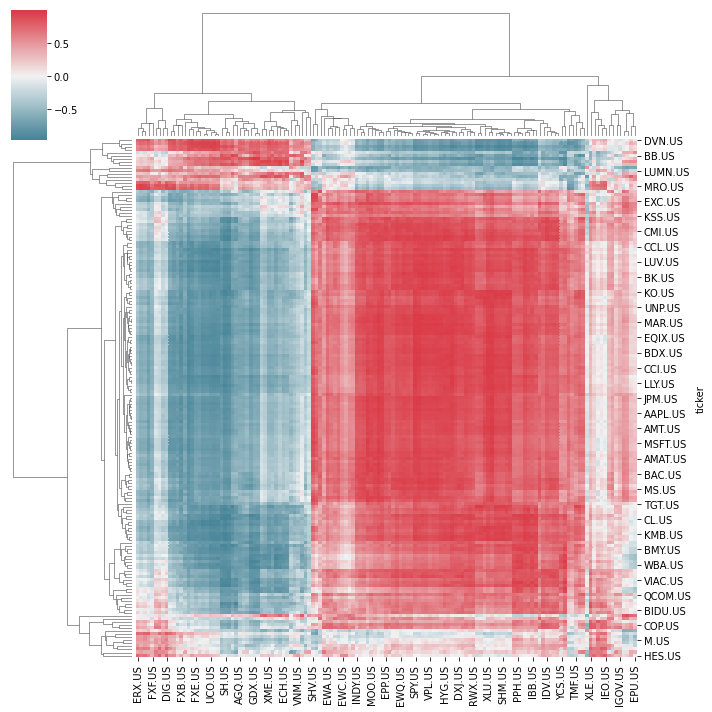

In [20]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

In [25]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [26]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [27]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

In [28]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

549 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

18.2 s ± 820 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
